# pre-HMP

In this notebook I will preprocess data to prepare it for HMP analysis.
The pipeline is implemented in the [Preprocessor.pre_hmp](preprocess.py#L152)
## The steps include:
1. **remove noisy channels**: channels that manually selected as noisy 
2. **filter data**: bandpass filter between 1 and 30 Hz and notch filter at 50 Hz
3. **epoch data**: locked to unicity point
4. **remove bad epochs**: A) epochs manually selected as noisy, B) epochs with not correct answer
5. **remove blick Ics components**: blink Ics are removed from the data
6. **apply autoreject**: detect an optimized amplitude threshold, interpolate noisy channels, and remove the epochs with more than 0.4 of bad channels
7. **Interpolate deleted channels and bridged channels**
8. **re-reference**: re-reference to the average of all channels

## requirement data 
1. raw bdf file for each subject id 
2. trial metadat exel files 
3. ica wieghts for each subject 
4. list of manually selected noisy channels, trials, Ics , all in one pickle file 

# Apply the pipline 

In [ ]:

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))# Add the parent directory to the path
from config import data_dir
from  Preprocessing import preprocess
import os
import numpy as np
import mne
import pickle


old_adults_ids = np.arange(601, 619)
young_adults_ids = [303, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 319]
all_ids = np.concatenate((old_adults_ids, young_adults_ids))

def submit_preprocess(ids, overwrite = False):
    for id in ids:
        path_epochs = os.path.join(data_dir, f'S{id}_epochs_preHMP.fif')
        if os.path.exists(path_epochs) and not overwrite:
            print(f"Skipping subject {id}, epochs file already exists.")
            continue
        print(f"Processing subject {id}")
        print('#################################################################################')
        try:
            preprocess(id, n_jobs= 4)
        except Exception as e:
            print(f"Error processing subject {id}: {e}")
            continue

# submit with submitit one job 
from submitit import AutoExecutor
executor = AutoExecutor(folder="logdir")
executor.update_parameters(cpus_per_task=4,  mem_gb=14, timeout_min=600)
job = executor.submit(submit_preprocess, all_ids)




# load and plot the log of the preprocessing steps for each subject

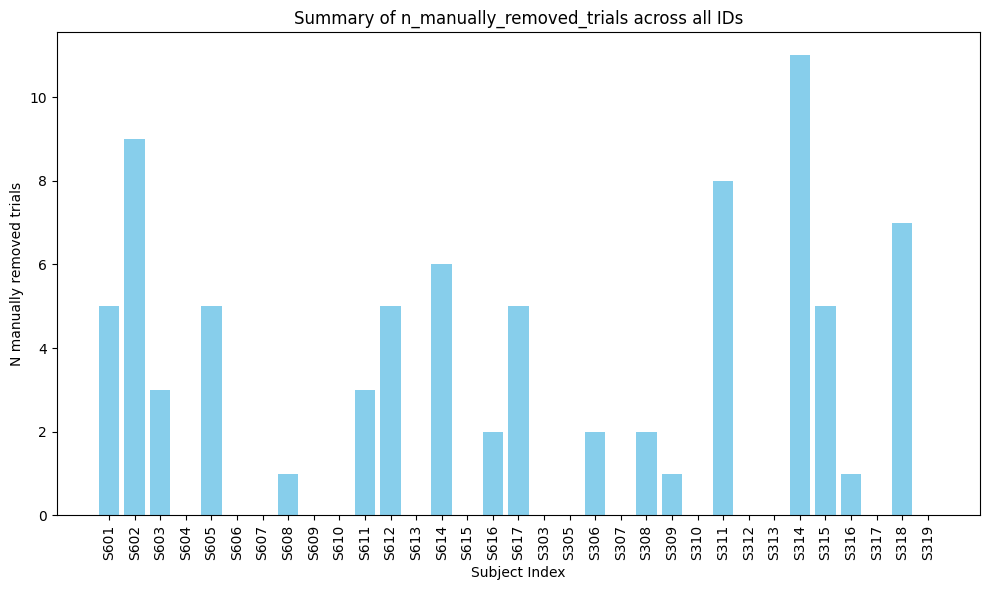

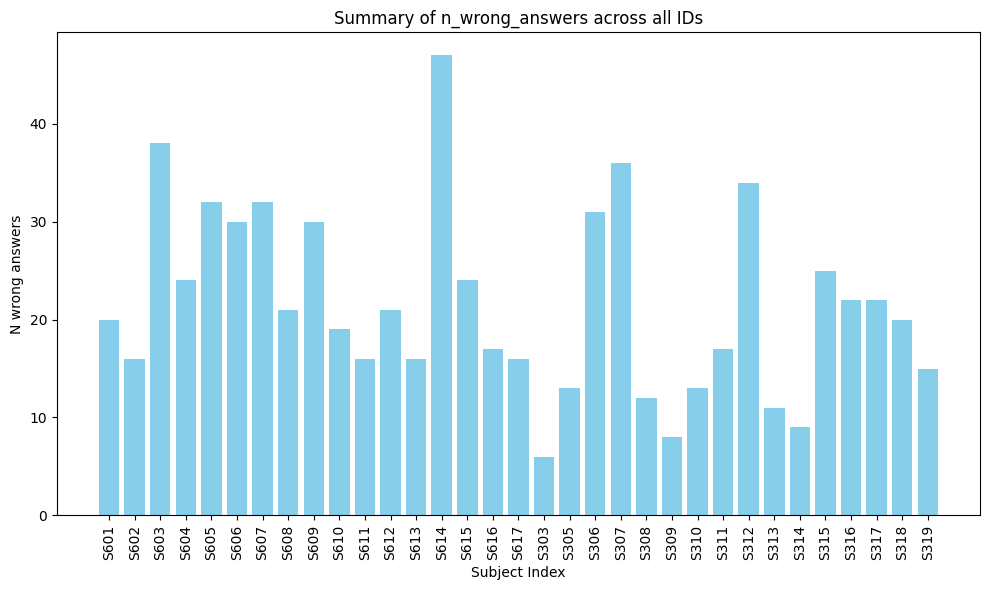

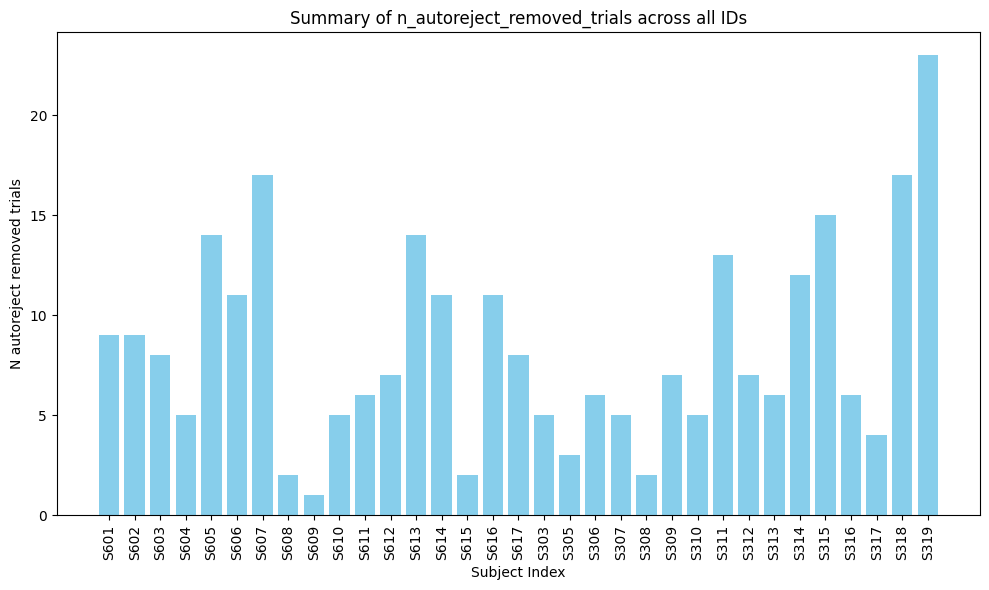

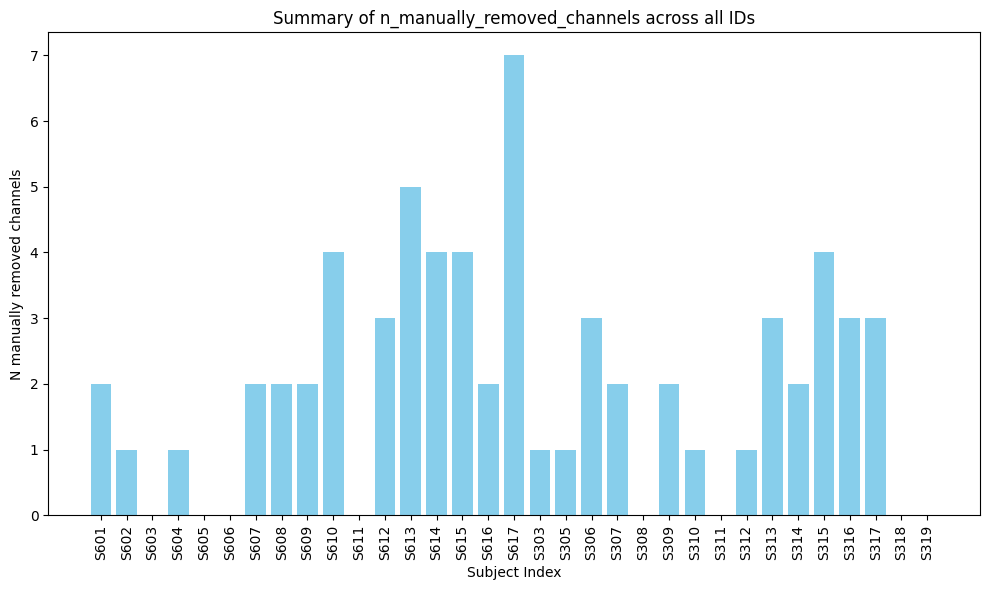

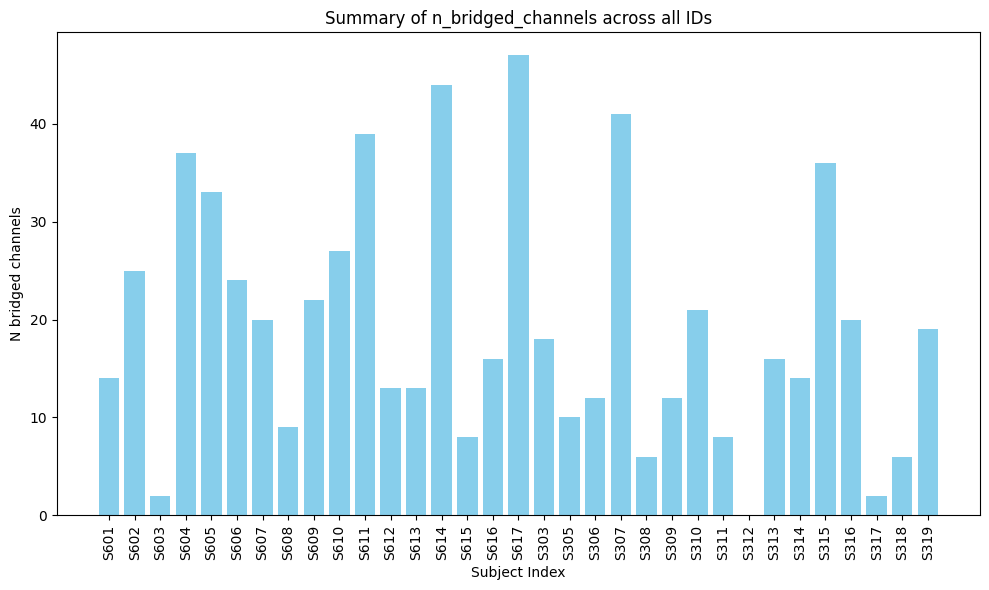

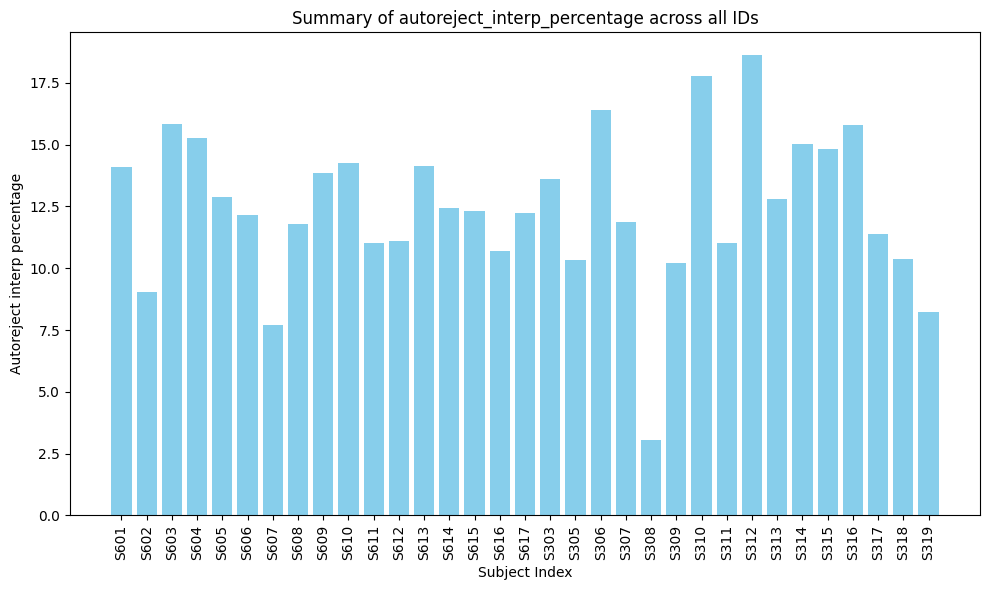

In [ ]:

import sys
import os
import numpy as np
import pickle
import mne
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))# Add the parent directory to the path
from config import data_dir
old_adults_ids = np.arange(601, 618)
young_adults_ids = [303, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319]

all_ids = np.concatenate((old_adults_ids, young_adults_ids))

all_logs = []

for id in all_ids:
    path_log = os.path.join(data_dir,'prehmp', f'S{id}_logs_preHMP.pkl')
    if os.path.exists(path_log):
        with open(path_log, 'rb') as f:
            logs = pickle.load(f)
        all_logs.append(logs)
    else:
        print(f"Log file for subject {id} does not exist.")



import matplotlib.pyplot as plt

# Initialize a dictionary to store aggregated data for each key
aggregated_logs = {
    'n_manually_removed_trials': [],
    'n_wrong_answers': [],
    'n_autoreject_removed_trials': [],
    'n_manually_removed_channels': [],
    'n_bridged_channels': [],
    'autoreject_interp_percentage': []
}

# Aggregate data from all logs
for log in all_logs:
    for key in aggregated_logs.keys():
        if key in log:
            aggregated_logs[key].append(log[key])
        else:
            aggregated_logs[key].append(0)  # Handle missing keys

# Plot each key in a separate figure
for key, values in aggregated_logs.items():
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(values)), values, color='skyblue')
    plt.title(f"Summary of {key} across all IDs")
    plt.xlabel("Subject Index")
    plt.ylabel(key.replace('_', ' ').capitalize())
    plt.xticks(range(len(values)), [f"S{id}" for id in all_ids], rotation=90)
    plt.tight_layout()
    plt.show()

BAD_subjects = {'id': [301,302,304],
                'reason': ['bidged_channels','bidged_channels', 'too_noisy_trials']}